## Global Macro Dashboard

An overview of some important indicators of the global economy's health.

### Import libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import quandl

import pandas_datareader.data as web
import datetime
import missingno as msno

from IPython.core.display import HTML

%matplotlib inline
plt.close('all')

### US Treasury bond yields

#### Load data US treasury bond yields

In [6]:
# load from Quandl API
US_treasury_yields = quandl.get("USTREASURY/YIELD", authtoken="e4FyZJfz6ukboUWG4Pm_")
# save a copy locally as a CSV
US_treasury_yields.to_csv("US_treasury_yields.csv")

#### Load US data on GDP, inflation etc from FRED

In [7]:
US_GDP = web.DataReader('GDP', 'fred')
US_inflation = web.DataReader(['CPIAUCSL', 'CPILFESL'], 'fred')

# FRED also has Treasury yield data available, but there seem to be more missing
# values compared to quandl, so using Quandl as above
# UST_3m_FRED = web.DataReader(['T10Y3MM'], 'fred', start, end)
# UST_2y_FRED = web.DataReader(['T10Y2Y'], 'fred', start, end)

In [33]:
display(HTML(US_treasury_yields.tail(10).to_html()))

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
2019-02-19,2.44,2.42,2.45,2.52,2.54,2.50,2.47,2.47,2.55,2.65,2.84,2.99
2019-02-20,2.41,2.42,2.45,2.51,2.54,2.50,2.47,2.47,2.55,2.65,2.84,3.00
2019-02-21,2.43,2.44,2.45,2.51,2.55,2.53,2.49,2.51,2.59,2.69,2.89,3.05
2019-02-22,2.43,2.45,2.46,2.51,2.55,2.48,2.46,2.47,2.55,2.65,2.86,3.02
2019-02-25,2.44,2.46,2.47,2.52,2.56,2.51,2.48,2.48,2.57,2.67,2.87,3.03
2019-02-26,2.43,2.44,2.45,2.52,2.56,2.48,2.44,2.45,2.54,2.64,2.84,3.01
2019-02-27,2.43,2.44,2.45,2.53,2.55,2.50,2.48,2.49,2.59,2.69,2.91,3.07
2019-02-28,2.44,2.47,2.45,2.50,2.54,2.52,2.50,2.52,2.63,2.73,2.94,3.09
2019-03-01,2.44,2.46,2.44,2.52,2.55,2.55,2.54,2.56,2.67,2.76,2.97,3.13


#### Checking for missing values

In [9]:
#msno.bar(US_treasury_yields.sample(7295), figsize=(8, 4))
#plt.show()

#### Visualising US Treasury yields for different tenors 

In [10]:
# set now to current time and date
now = datetime.datetime.now()
# set a start date in the past
start = datetime.datetime(2013, 1, 1)
# other start/end options: 
# start = '20120101'
# end = ''
today = datetime.datetime(now.year, now.month, now.day)

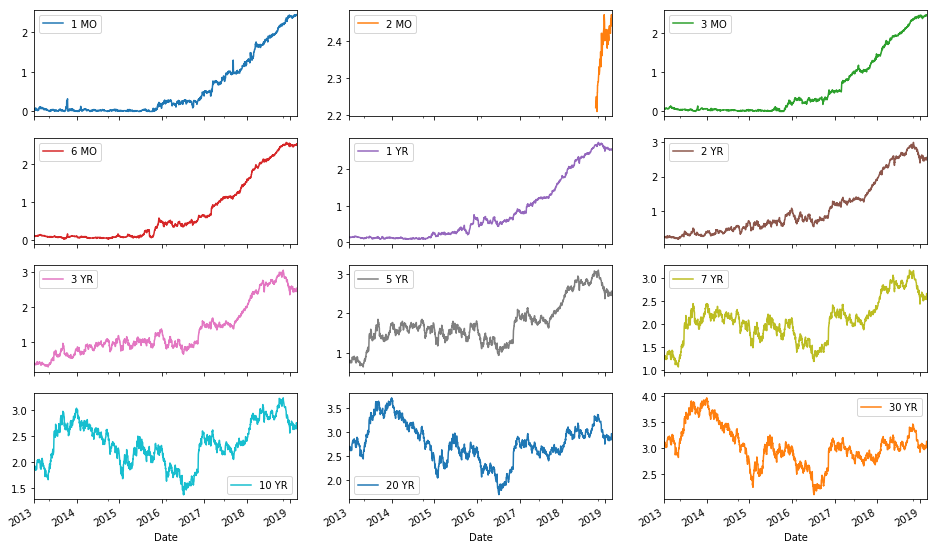

In [11]:
US_treasury_yields.loc[start:].plot(subplots=True, layout=(4,3), figsize=(16, 10))
plt.show();

#### US Treasury yield curves 

In [12]:
TSY3m2y =  US_treasury_yields['2 YR'] - US_treasury_yields['3 MO']
TSY2y10y = US_treasury_yields['10 YR'] - US_treasury_yields['2 YR']

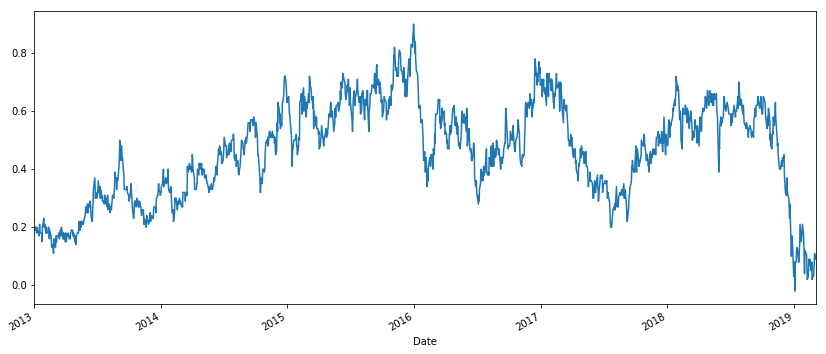

In [13]:
TSY3m2y.loc[start:].plot(figsize=(14, 6))
plt.show();

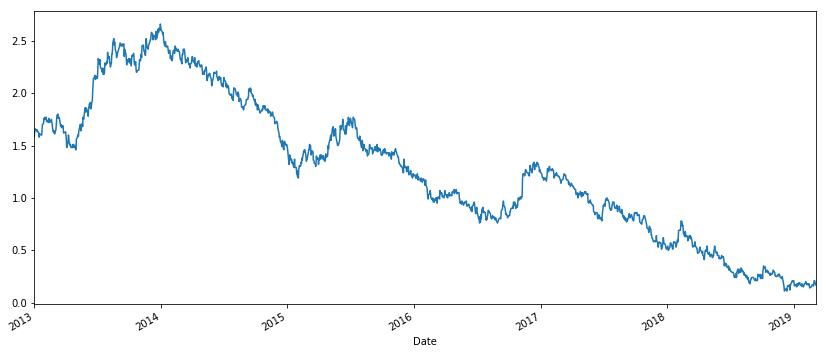

In [14]:
TSY2y10y.loc[start:].plot(figsize=(14, 6))
plt.show();

## Germany bond yields and curves

### Data sources

In [15]:
# creates list of bond tenors
tenor = ['6m', '1y', '2y', '5y','10y', '20y', '30y']

# creates dictionary where keys represent various bond tenors and the value is the URL of corresponding dataset
DE = {"DE6m_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3210&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=",
      "DE1y_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3211&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=",
      "DE2y_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3213&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=",
      "DE5y_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3219&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=",
      "DE10y_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3229&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=",
      "DE20y_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3449&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to=",
      "DE30y_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3500&mode=its&its_fileFormat=csv&its_csvFormat=de&its_currency=default&its_dateFormat=default&its_from=&its_to="}

### Functions for loading, cleaning and concatenating data

In [16]:
def instrument_names(tenors):
    """
    creates variable names for each instrument, e.g. "DE2y" for a
    2yr German bond and also input variables that will be used in
    subsequent cleaning functions, e.g. DE2y_input
    """
    input_names = [0] * len(tenors)
    
    for i in tenors:
        index = tenors.index(i)
    
    if index < len(tenors):
            tenors[index] = 'DE'+ i
            input_names[index] = tenors[index] + '_input'
    
    return tenors, input_names

def bunds_clean(URL, tenor):
    """
    Loads and transforms very poorly formatted CSV files with data for each
    bond tenor from German Bundesbank and returns cleaned pandas dataframe
    """
    assert type(tenor) == str, "Tenor needs to be a string"
    
    DF = pd.read_csv(URL, sep=';')   
            
    # remove rows without relevant data
    DF = DF[4:-1]
    
    # rename columns to give meaningful name
    new_columns = DF.columns.values
    new_columns[0] = 'DATE'
    new_columns[1] = tenor 
    DF.columns = new_columns   
    
    # assign last column to variable 'dropcolumn'
    dropcolumn = DF.columns[2]
    
    # use dropcolumn to remove rows that have missing values (indicated by string in German instead of NaN)
    DF = DF[DF[dropcolumn] != 'Kein Wert vorhanden']
    
    # now remove last column 
    DF = DF.drop([dropcolumn], axis=1)
    
    # reset dataframe index to 0 - was not the case because we removed rows earlier
    DF.reset_index(drop=True, inplace=True)    
    
    # replace German comma (,) with dot in RATE column
    DF[tenor] = [x.replace(',', '.') for x in DF[tenor]]
    
    # convert RATE column values from string to float
    DF[tenor] = DF[tenor].astype('float')
    
    # convert DATE column values from string to datetime
    DF['DATE'] = pd.to_datetime(DF['DATE'])
    
    # replace dataframe index column with DATE column
    DF.set_index(['DATE'], drop=True, inplace=True)
    
    return DF

def clean_and_join(input_name, tenor):
    """
    Calls bunds_clean function for each input file and concatenates 
    cleaned output into one pandas dataframe, which is returned
    """
    combined = pd.DataFrame() 
    
    for i in range(len(tenor)):
        result = bunds_clean(DE[input_name[i]], tenor[i])
        combined = pd.concat([combined, result], axis=1)
    
    return combined

In [17]:
results = instrument_names(tenor[:])
instruments = results[0]
input_name = results[1]

DE_bond_yields = clean_and_join(input_name, tenor)

DE_bond_yields.to_csv("DE_bond_yields.csv")

In [34]:
display(HTML(DE_bond_yields.tail(10).to_html()))

,6m,1y,2y,5y,10y,20y,30y
DATE,,,,,,,
2019-02-20,-0.57,-0.59,-0.59,-0.39,0.07,0.62,0.78
2019-02-21,-0.57,-0.58,-0.57,-0.36,0.09,0.64,0.79
2019-02-22,-0.57,-0.58,-0.57,-0.36,0.09,0.64,0.79
2019-02-25,-0.57,-0.58,-0.56,-0.35,0.10,0.63,0.78
2019-02-26,-0.58,-0.58,-0.56,-0.36,0.09,0.61,0.83
2019-02-27,-0.57,-0.57,-0.56,-0.36,0.11,0.63,0.84
2019-02-28,-0.57,-0.57,-0.55,-0.32,0.15,0.66,0.86
2019-03-01,-0.56,-0.56,-0.53,-0.30,0.17,0.70,0.92
2019-03-04,-0.54,-0.55,-0.53,-0.30,0.16,0.69,0.92


#### Checking for missing data

In [19]:
#msno.bar(DE_bond_yields.sample(5473), figsize=(8, 3))
#plt.show()

#### Visualising German bond yields for different tenors 

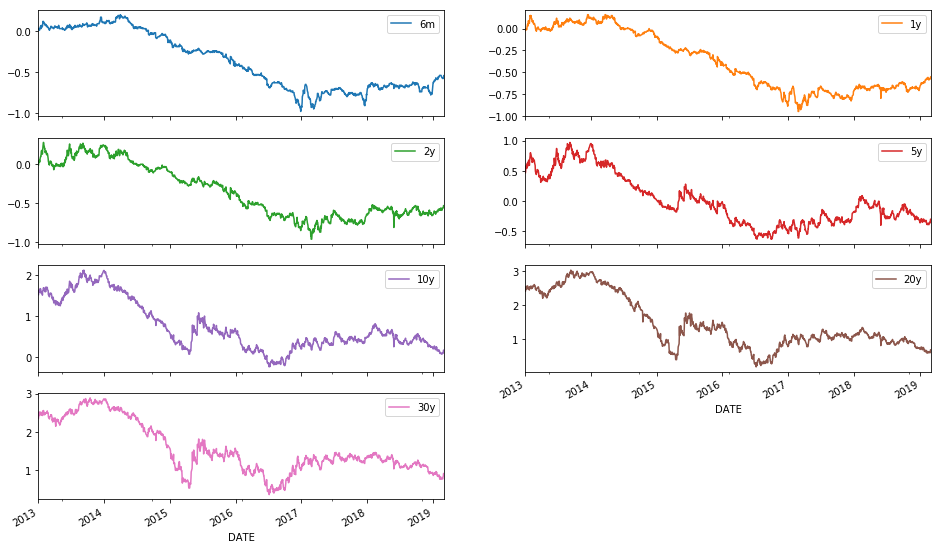

In [20]:
start = '20130101'
end = today
DE_bond_yields.loc[start:].plot(subplots=True, layout=(4,2), figsize=(16, 10))
plt.show();

#### German yield curves

In [21]:
DE2y10y = DE_bond_yields['10y'] - DE_bond_yields['2y']

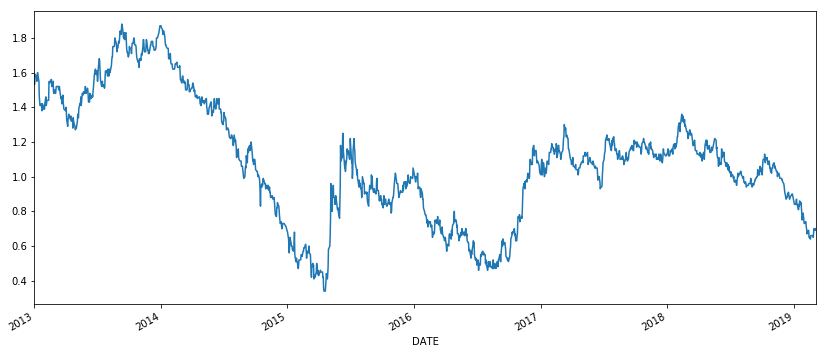

In [22]:
DE2y10y.loc[start:].plot(figsize=(14, 6))
plt.show();

#### Todo

In [23]:
# Write function for DE yield curves

#def generate_yieldcurves:

#DE_yield_curve = pd.DataFrame()
#DE_yield_curve['2y10y'] =  DE_bond_yields.apply(lambda x: x['10y'] - x['2y'], axis=1)

#def clean_and_join(input_name, tenor):
#    """
#    """
#    combined = pd.DataFrame() 
#    for i in range(len(tenor)):
#        result = bunds_clean(DE[input_name[i]], tenor[i])
#        combined = pd.concat([combined, result], axis=1)
#    return combined